In [1]:
import numpy as np
# from time import time
# import vegas

def get_mesh_spheres_volume(
        rs: list[float], centers: list[np.ndarray], ncubes: int = 1000000):
    """ Returns the mesh-integrated volume of union of spheres

    Args:
        rs (list[float]): Radii of each sphere
        centers (list[np.ndarray]): Center of each sphere
        ncubes (int): Approximate number of cubes used in integration

    Returns:
        float: Mesh-integrated volume
    """
    minx, miny, minz = [min([c[i] - r for c, r in zip(centers, rs)]) for i in range(3)]
    maxx, maxy, maxz = [max([c[i] + r for c, r in zip(centers, rs)]) for i in range(3)]
    spans = [maxx - minx, maxy - miny, maxz - minz]
    vol_tot = spans[0] * spans[1] * spans[2]
    dstep = (vol_tot / float(ncubes)) ** (1/3)
    nx, ny, nz = [int(np.round(sp / dstep)) for sp in spans]
    # print(f"Using {np.prod([nx, ny, nz])} cubes for volume integration (approx {ncubes} requested)")
    x, y, z = np.meshgrid(
        np.linspace(minx, maxx, nx),
        np.linspace(miny, maxy, ny),
        np.linspace(minz, maxz, nz),
    )
    x_flat, y_flat, z_flat = x.flatten(), y.flatten(), z.flatten()
    points = np.vstack((x_flat, y_flat, z_flat)).T
    distancess = [np.linalg.norm(points - c, axis=1) for c in centers]
    inside_any_sphere = np.zeros(len(points), dtype=bool)
    for r, distances in zip(rs, distancess):
        inside_sphere = distances <= r
        inside_any_sphere = inside_any_sphere | inside_sphere
    vol = np.sum(inside_any_sphere)
    dV = ((maxx - minx)/nx) * ((maxy - miny)/ny) * ((maxz - minz)/nz)
    return vol * dV


def convergence_mesh_spheres_volume(
        rs: list[float], centers: list[np.ndarray], ncubes_list: list[int]) -> list[float]:
    vols = []
    for ncubes in ncubes_list:
        vol = get_mesh_spheres_volume(rs, centers, ncubes=ncubes)
        vols.append(vol)
    return vols

def get_monte_carlo_spheres_volume(
        rs: list[float], centers: list[np.ndarray], npoints: int = 1000000) -> float:
    """ Returns the Monte-Carlo-integrated volume of union of spheres

    Args:
        rs (list[float]): Radii of each sphere
        centers (list[np.ndarray]): Center of each sphere
        npoints (int): Number of samples used in integration

    Returns:
        float: Monte-Carlo-integrated volume
    """
    count_inside = 0
    min_coords = np.min([c - r for c, r in zip(centers, rs)], axis=0)
    max_coords = np.max([c + r for c, r in zip(centers, rs)], axis=0)
    for _ in range(npoints):
        point = np.random.uniform(min_coords, max_coords)
        inside_any_sphere = False
        for r, c in zip(rs, centers):
            distance = np.linalg.norm(point - c)
            if distance <= r:
                inside_any_sphere = True
                break
        if inside_any_sphere:
            count_inside += 1
    cube_volume = np.prod(max_coords - min_coords)
    count_mean = count_inside / npoints
    spheres_volume = (count_mean) * cube_volume
    # Since the results of this simulation is binary, we can make the evaluation
    # of the variance much quicker.
    stdev = np.sqrt(
        (
            count_inside * ((cube_volume - spheres_volume)**2) + 
            (npoints - count_inside) * ((spheres_volume)**2)
        ) / npoints
    )
    sem = stdev / np.sqrt(npoints)
    return spheres_volume, sem

import timeit

def time_mesh_spheres_volume(rs: list[float], centers: list[np.ndarray], ncubes: int = 1000000, runs=5):
    def time_fn():
        get_mesh_spheres_volume(rs, centers, ncubes=ncubes)
    code_snippet = f'time_fn()'
    return timeit.timeit(code_snippet, globals={"time_fn": time_fn}, number=runs)

def time_mc_spheres_volume(rs: list[float], centers: list[np.ndarray], npoints: int = 1000000, runs=5):
    def time_fn():
        get_monte_carlo_spheres_volume(rs, centers, npoints=npoints)
    code_snippet = f'time_fn()'
    return timeit.timeit(code_snippet, globals={"time_fn": time_fn}, number=runs)

###############################

def get_mesh_spheres_volume_new(
        rs: list[float], centers: list[np.ndarray], ncubes: int = 1000000):
    """ Returns the mesh-integrated volume of union of spheres

    Args:
        rs (list[float]): Radii of each sphere
        centers (list[np.ndarray]): Center of each sphere
        ncubes (int): Approximate number of cubes used in integration

    Returns:
        float: Mesh-integrated volume
    """
    minx, miny, minz = [min([c[i] - r for c, r in zip(centers, rs)]) for i in range(3)]
    maxx, maxy, maxz = [max([c[i] + r for c, r in zip(centers, rs)]) for i in range(3)]
    spans = [maxx - minx, maxy - miny, maxz - minz]
    vol_tot = spans[0] * spans[1] * spans[2]
    dstep = (vol_tot / float(ncubes)) ** (1/3)
    nx, ny, nz = [int(np.round(sp / dstep)) for sp in spans]
    x, y, z = np.meshgrid(
        np.linspace(minx, maxx, nx),
        np.linspace(miny, maxy, ny),
        np.linspace(minz, maxz, nz),
    )
    x_flat, y_flat, z_flat = x.flatten(), y.flatten(), z.flatten()
    points = np.vstack((x_flat, y_flat, z_flat)).T
    distancess = [np.linalg.norm(points - c, axis=1) for c in centers]
    inside_any_sphere = np.zeros(len(points), dtype=bool)
    for r, distances in zip(rs, distancess):
        inside_sphere = distances <= r
        inside_any_sphere = inside_any_sphere | inside_sphere
    vol = np.sum(inside_any_sphere)
    dV = ((maxx - minx)/nx) * ((maxy - miny)/ny) * ((maxz - minz)/nz)
    return vol * dV


def convergence_mesh_spheres_volume_new(
        rs: list[float], centers: list[np.ndarray], ncubes_list: list[int]) -> list[float]:
    vols = []
    for ncubes in ncubes_list:
        vol = get_mesh_spheres_volume_new(rs, centers, ncubes=ncubes)
        vols.append(vol)
    return vols

def get_monte_carlo_spheres_volume_new(
        rs: list[float], centers: list[np.ndarray], npoints: int = 1000000) -> float:
    """ Returns the Monte-Carlo-integrated volume of union of spheres

    Args:
        rs (list[float]): Radii of each sphere
        centers (list[np.ndarray]): Center of each sphere
        npoints (int): Number of samples used in integration

    Returns:
        float: Monte-Carlo-integrated volume
    """
    rs = np.array(rs)
    centers = np.array(centers)
    min_coords = np.min([c - r for c, r in zip(centers, rs)], axis=0)
    max_coords = np.max([c + r for c, r in zip(centers, rs)], axis=0)
    cube_vol = np.prod(max_coords - min_coords)
    
    def f(x):
        dminr = np.linalg.norm(x - centers, axis=1) - rs
        return float(np.any(dminr <= 0))*cube_vol
    points = np.random.uniform(min_coords, max_coords, size=(npoints, 3))
    results = np.array([f(point) for point in points])
    mean = np.mean(results)
    sem = np.std(results) / np.sqrt(npoints)
    return mean, sem


def time_mesh_spheres_volume_new(rs: list[float], centers: list[np.ndarray], ncubes: int = 1000000, runs=5):
    def time_fn():
        get_mesh_spheres_volume_new(rs, centers, ncubes=ncubes)
    code_snippet = f'time_fn()'
    return timeit.timeit(code_snippet, globals={"time_fn": time_fn}, number=runs)

def time_mc_spheres_volume_new(rs: list[float], centers: list[np.ndarray], npoints: int = 1000000, runs=5):
    def time_fn():
        get_monte_carlo_spheres_volume_new(rs, centers, npoints=npoints)
    code_snippet = f'time_fn()'
    return timeit.timeit(code_snippet, globals={"time_fn": time_fn}, number=runs)

def race_mc_spheres_volume(rs: list[float], centers: list[np.ndarray], npoints: int = 1000000):
    t_old = time_mc_spheres_volume(rs, centers, npoints=npoints)
    t_new = time_mc_spheres_volume_new(rs, centers, npoints=npoints)
    return t_old, t_new

def average_races_mc_spheres_volume(rs: list[float], centers: list[np.ndarray], npoints: int = 1000000, nraces: int = 10):
    ratios = []
    difs = []
    for _ in range(nraces):
        t_old, t_new = race_mc_spheres_volume(rs, centers, npoints=npoints)
        ratios.append(t_new/t_old)
        difs.append(t_new - t_old)
    return ratios, difs

def race_mesh_spheres_volume(rs: list[float], centers: list[np.ndarray], ncubes: int = 1000000, runs=5):
    t_old = time_mesh_spheres_volume(rs, centers, ncubes=ncubes, runs=runs)
    t_new = time_mesh_spheres_volume_new(rs, centers, ncubes=ncubes, runs=runs)
    return t_old, t_new

def average_races_mesh_spheres_volume(rs: list[float], centers: list[np.ndarray], ncubes: int = 1000000, nraces: int = 10, runs=5):
    ratios = []
    difs = []
    t_olds = []
    for _ in range(nraces):
        t_old, t_new = race_mesh_spheres_volume(rs, centers, ncubes=ncubes, runs=runs)
        ratios.append(t_new/t_old)
        difs.append(t_new - t_old)
        t_olds.append(t_old)
    # First race is often an outlier due to caching effects
    return ratios[1:], difs[1:], t_olds[1:]



m: 1.0
h1: 1.0
h2: 0.0
V11: 0.5235987755982989
V21: 0.0
V2: 0.5235987755982988
Analytical volume: 1.0471975511965979
Separated analytical volume: 1.0471975511965976


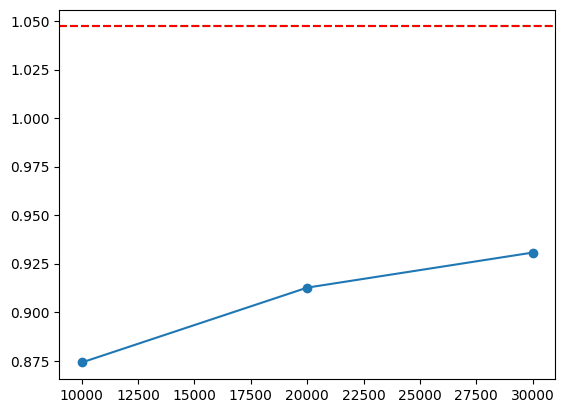

In [12]:
from JDFTxFreeNrg.testing import anl_sphere_volume
import matplotlib.pyplot as plt
rs = [0.5, 0.5]
d = 2.0
centers = [np.zeros(3)]
centers.append(np.array([d, 0.0, 0.0]))
nsampless = [1e4, 2e4, 3e4]
def anl_2sphere_union_volume(r1: float, r2: float, l: float):
    """Return volume of a sphere.

    Args:
        r (float): Radius of the sphere.

    Returns:
        float: Volume of the sphere.
    """
    m = ((r2**2) - (r1**2) + (l**2))/(2*l)
    # m = max(0.0, ((r2**2) - (r1**2) + (l**2))/(2*l))
    print(f"m: {m}")
    # h1 = r1 + l - m
    # h1 = max(0.0, r1 + l - m)
    h1 = min(r1 + l - m, 2*r1)
    print(f"h1: {h1}")
    # h2 = r2 - m
    h2 = max(0.0, r2 - m)
    print(f"h2: {h2}")
    V11 = np.pi*(h1**2)*(r1-(h1/3))
    print(f"V11: {V11}")
    V21 = np.pi*(h2**2)*(r2-(h2/3))
    print(f"V21: {V21}")
    V2 = anl_sphere_volume(r2)
    print(f"V2: {V2}")
    return V11 + V2 - V21
anl_vol = anl_2sphere_union_volume(rs[0], rs[1], np.linalg.norm(centers[0]-centers[1]))
sep_anl_vol = anl_sphere_volume(rs[0]) + anl_sphere_volume(rs[1])
print(f"Analytical volume: {anl_vol}")
print(f"Separated analytical volume: {sep_anl_vol}")
vols = convergence_mesh_spheres_volume(rs, centers, ncubes_list=[int(ns) for ns in nsampless])
plt.plot(nsampless, vols, marker='o', label='Mesh Volume')
plt.axhline(anl_vol, color='green', linestyle='--', label='Analytical Volume')
plt.axhline(sep_anl_vol, color='red', linestyle='--', label='Separated Analytical Volume')


In [43]:
rs = [0.5, 0.5]
centers = [np.zeros(3), np.ones(3)]
nsamples = 2e6
ratios, difs, t_olds = average_races_mesh_spheres_volume(rs, centers, ncubes=int(nsamples), nraces=5, runs=20)
print(f"Average ratio of new to old Mesh times: {np.mean(ratios):.6f}")
print(f"Average difference of new to old Mesh times: {np.mean(difs):.6f} / {np.mean(t_olds):.6f}")

Average ratio of new to old Mesh times: 1.017650
Average difference of new to old Mesh times: 0.034795 / 1.968596


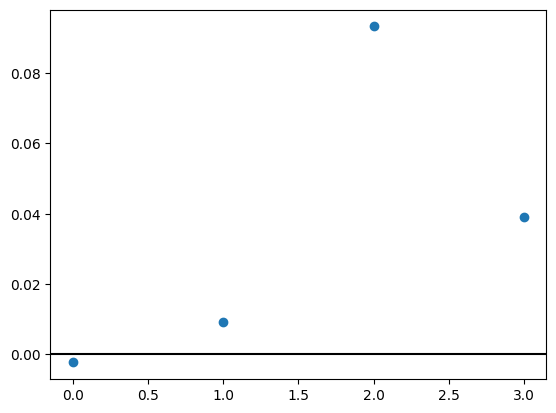

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(range(len(difs)), difs)
ax.axhline(0, color='black')

In [18]:
rs = [0.5, 0.5]
centers = [np.zeros(3), np.ones(3)]
nsamples = 1e4
ratios, difs = average_races_mc_spheres_volume(rs, centers, npoints=int(nsamples), nraces=10)
print(f"Average ratio of new to old Monte Carlo times: {np.mean(ratios):.6f}")
print(f"Average difference of new to old Monte Carlo times: {np.mean(difs):.6f}")

Average ratio of new to old Monte Carlo times: 0.851935
Average difference of new to old Monte Carlo times: -0.129796


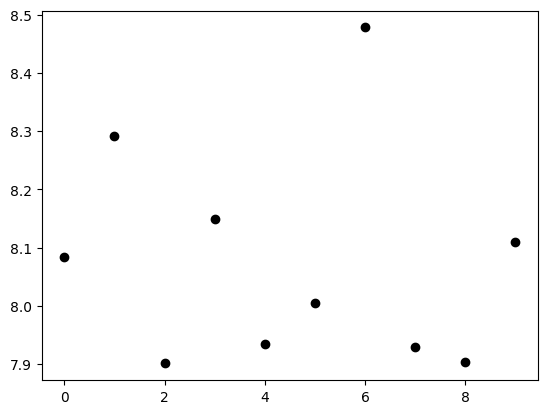

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(range(len(difs)), difs, c="black")

Average ratio of new to old Monte Carlo times: 1.009176
Average difference of new to old Monte Carlo times: 0.011621


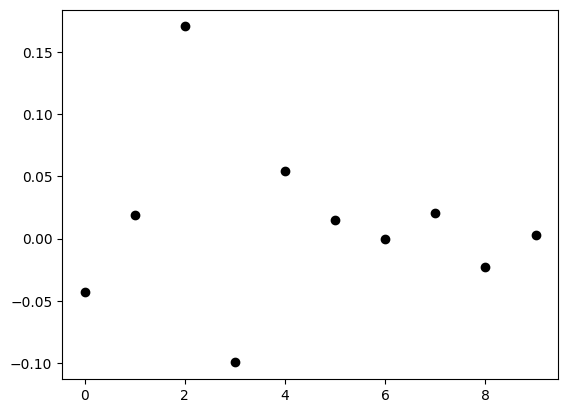

In [ ]:
r = 0.5
center = np.zeros(3)
nsamples = 1e5
ratios, difs = average_races_mc_spheres_volume([r], [center], npoints=int(nsamples))
print(f"Average ratio of new to old Monte Carlo times: {np.mean(ratios):.6f}")
print(f"Average difference of new to old Monte Carlo times: {np.mean(difs):.6f}")
fig, ax = plt.subplots()
ax.scatter(range(len(difs)), difs, c="black")